# 0. Pre-Processing

### 0.1. Mount Drive

### 0.2. Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [ ]:
!unzip Myproj-20230502T210234Z-001.zip


Archive:  Myproj-20230502T210234Z-001.zip
   creating: Myproj/logs/
   creating: Myproj/output/
   creating: Myproj/.ipynb_checkpoints/
  inflating: Myproj/requirements.txt  
  inflating: Myproj/images/t5.jpg    
  inflating: Myproj/images/ahmad.jpg  
  inflating: Myproj/man.jpg          
   creating: Myproj/images/.ipynb_checkpoints/
  inflating: Myproj/dataset/test.json  
  inflating: Myproj/images/t2.jpg    
  inflating: Myproj/detectron2_repo/LICENSE  
  inflating: Myproj/mrcnn/parallel_model.py  
  inflating: Myproj/detectron2_repo/.gitignore  
  inflating: Myproj/images/ko.jpg    
  inflating: Myproj/mrcnn/__pycache__/config.cpython-310.pyc  
  inflating: Myproj/detectron2_repo/MODEL_ZOO.md  
  inflating: Myproj/Coco/__pycache__/coco.cpython-310.pyc  
  inflating: Myproj/images/f2.jpg    
  inflating: Myproj/images/t3.jpg    
  inflating: Myproj/mrcnn/visualize.py  
  inflating: Myproj/images/t1.jpg    
  inflating: Myproj/mrcnn/__init__.py  
  inflating: Myproj/detectron2_repo/s

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Myproj')

In [ ]:
# you may need to restart runtime after installation
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-aofeij87
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-aofeij87
  Resolved https://github.com/facebookresearch/fvcore.git to commit 51092b5515cbb493f73de079743dd6b11cc4bbf1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-048nry2n
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-048nry2n
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.0 MB/s eta 0:00:0

### 0.3. Import Modules

In [ ]:
import torch, torchvision
import numpy as np
import pandas as pd
import random
import json
import cv2
import os
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Myproj/detectron2_repo/')
import detectron2
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
setup_logger()

import itertools
from itertools import groupby
from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskutil
from pycocotools import mask as maskUtils

# 1. Create Dataset Instance

In [ ]:
# register training and test datasets to Detectron2
register_coco_instances("T1", {}, "/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/pascal_train.json", "/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/train_images/")
register_coco_instances("V1", {}, "/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/test.json", "/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/test_images/")

# metadata
train_metadata = MetadataCatalog.get("T1")
test_metadata = MetadataCatalog.get("V1")

# dataset dictionary
train_dataset_dicts = DatasetCatalog.get("T1")
test_dataset_dicts = DatasetCatalog.get("V1")

AssertionError: ignored

### 1.1. Visualize if images are correctly loaded

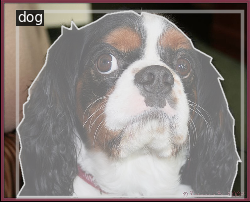

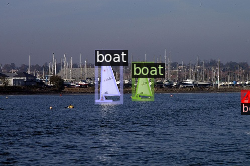

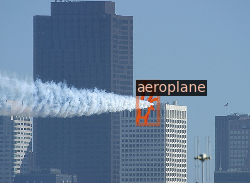

In [ ]:
for d in random.sample(train_dataset_dicts, 3):
    image = cv2.imread(d["file_name"])
    visualizer = Visualizer(image[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# 2. Train Detectron2

### 2.1. Define Training Configuration

In [ ]:
cfg = get_cfg()

# load ImageNet pretrained weights
cfg.merge_from_file("/content/drive/MyDrive/Colab Notebooks/Myproj/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# load dataset
cfg.DATASETS.TRAIN = ("T")

# parameters
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 28
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20

### 2.2. Train the Model

In [ ]:

from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/03 02:34:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: ignored

# 5. Compute Results

### 5.1. Define configuration

In [ ]:
from detectron2 import model_zoo
# load weights

from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Colab Notebooks/Myproj/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# define min score threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# choose dataset
cfg.DATASETS.TEST = ("V")

# load training annotations
coco = COCO('/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/pascal_train.json')

# save categories
CLASS_NAMES = [coco.cats[k]['name'] for k in coco.cats.keys()]

# metadata
test_metadata.set(thing_classes=CLASS_NAMES)

# define predictor
predictor = DefaultPredictor(cfg)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
[05/03 02:14:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


### 5.2. Make predictions

In [ ]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

# load test annotations
cocoGt = COCO("/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/test.json")

# store results
coco_dt = []

for imgid in cocoGt.imgs:
    # read test image
    image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/test_images/" + cocoGt.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1]

    # make prediction
    outputs = predictor(image)

    # parse prediction
    boxes = (outputs['instances']._fields['pred_boxes'].tensor).cpu().numpy()
    scores = (outputs['instances']._fields['scores']).cpu().numpy()
    categories = (outputs['instances']._fields['pred_classes']).cpu().numpy()
    masks = (outputs['instances']._fields['pred_masks']).cpu().numpy()
    n_instances = len(scores)
    if len(categories) > 0:
        for i in range(n_instances):
            pred = {}
            pred['image_id'] = imgid
            pred['category_id'] = int(categories[i]) + 1
            pred['segmentation'] = binary_mask_to_rle(masks[i,:,:])
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 5.3. Output JSON file

In [ ]:
with open('0845086_25.json', 'w') as f:
    f.write(pd.Series(coco_dt).to_json(orient='values'))
f.close()

### 5.4. Visualize Prediction

[05/03 02:59:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


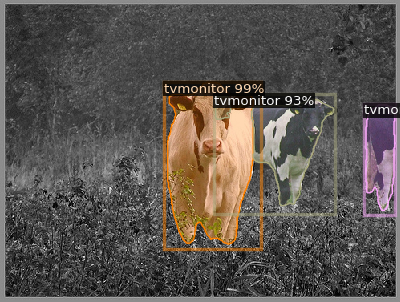

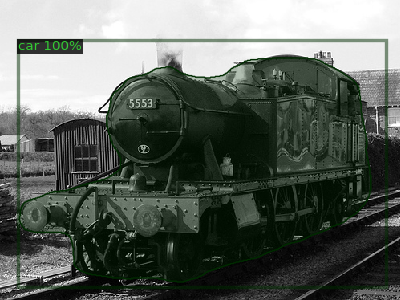

IndexError: ignored

In [ ]:
cfg.MODEL.WEIGHTS =  model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.DATASETS.TEST = ("V")
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 10):
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
cfg.DATASETS.TEST = ("V")




# Create evaluator object
evaluator = COCOEvaluator("test_images", cfg, False, output_dir="./output")

# Create data loader for test set
data_loader = build_detection_test_loader(cfg, "/content/drive/MyDrive/Colab Notebooks/Myproj/dataset/test.json")

# Perform inference on test set
results = inference_on_dataset(trainer.model, data_loader, evaluator)

# Print results
print(results["segm"])

WARNING [05/03 02:59:36 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


FileNotFoundError: ignored

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
dataset_name="test_images"

evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir="./output/" )

data_loader = build_detection_test_loader(cfg, dataset_name)

results = inference_on_dataset(trainer.model, data_loader, evaluator)

print("mAP:"+str(results["segm"]))


WARNING [05/03 03:04:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


FileNotFoundError: ignored